# Reconstruction demo

An introductory example showing a reconstruction pipeline using `simplecryoem`.

In [1]:
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax import random

from simplecryoem.emfiles import load_data
from simplecryoem.preprocess import preprocess
from simplecryoem.forwardmodel import Slice
from simplecryoem.optimization import Loss, GradV, sgd, get_sgd_vol_ops, precon_sgd
from simplecryoem.utils import mip_x, mip_y, mip_z

2024-10-04 23:55:57.583099: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data

First, use the `load_data` function to load the particle images from the _mrcs_ file and their parameters from the _star_ file.

In [3]:
data_dir = "../../../Relion5_SPA_tutorial/"
star_file = "Refine3D/job029/run_data.star"

In [4]:
# data_dir = "../../../Datasets/EMPIAR_10076/data/"
# star_file = "particles.star"

In [5]:
params0, imgs0 = load_data(data_dir, star_file, load_imgs=True, fourier=False)

print(f"params0 keys: {params0.keys()}")
print(f"imgs0.shape = {imgs0.shape}")

load_data: number of partcles: 4452
load_data: data loaded, time:  1.87 sec.
params0 keys: dict_keys(['ctf_params', 'pixel_size', 'angles', 'shifts'])
imgs0.shape = (4452, 256, 256)


### Preprocess the data

Some basic preprocessing: compute the Fourier transform of the images and extract the angles, shifts and the CTF parameters from the `params0` dictionary.

In [6]:
processed_data = preprocess(imgs0, params0)

imgs0.shape = (4452, 256, 256)
pixel_size0.shape = (4452,)
angles0.shape = (4452, 3)
shifts0.shape = (4452, 2)
ctf_params0.shape = (4452, 9)
N0 = 4452
idx not provided
N = 4452
Taking FFT of the images:
Batch 1/10  0.56 sec.
Batch 2/10  0.56 sec.
Batch 3/10  0.56 sec.
Batch 4/10  0.56 sec.
Batch 5/10  0.56 sec.
Batch 6/10  0.56 sec.
Batch 7/10  0.56 sec.
Batch 8/10  0.56 sec.
Batch 9/10  0.56 sec.
Batch 10/10  0.56 sec.
FFT done. Time:  6.09 sec.
x_grid = [3.13796608e-03 2.56000000e+02]
Vectorised imgs_f.shape = (4452, 65536)
Mask radius = 0.39852169162981443
Noise free, setting sigma_noise = 1


In [7]:
# Images and image-specific parameters
# (orientation angles, in-plane shifts, ctf parameters)
imgs_f = processed_data["imgs_f"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]

# These parameters are the same for all images
pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

Display a projection image.

Text(0.5, 1.0, 'Real space')

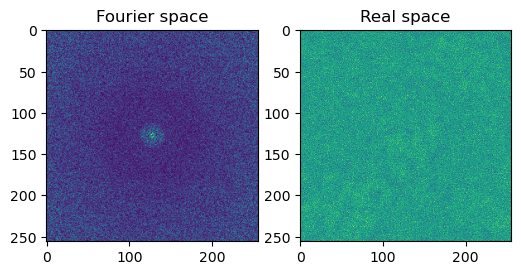

In [8]:
img_index = 130

plt.subplot(121)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_index].reshape([nx, nx]))))
plt.title("Fourier space")

plt.subplot(122)
plt.imshow(
    jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(imgs_f[img_index].reshape([nx, nx]))))
)
plt.title("Real space")

One last preprocessing step is to apply a spherical mask to avoid issues related to rotating voxels from the corners of the 3D grid.

In [9]:
# Use the x=0 slice of the 3D mask output by the preprocess function
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

Dispay the mask and a masked image

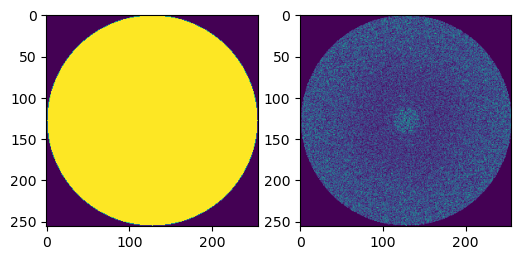

In [10]:
plt.subplot(1, 2, 1)
plt.imshow(jnp.fft.fftshift(mask[0]))

plt.subplot(1, 2, 2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[123].reshape([nx, nx]))))

### Reconstruction

First, we set:
* The egularization parameter $\alpha$ that will be used in the loss function
* The interpolation method: since the forward model involves rotating the input volume (or the coordinates), the rotated volume and the coordinate grid will end up misaligned. We compute the value of the rotated volume at the off-the-grid points using trilinear or nearest-neighbour interpolation.

In [11]:
# Regularization parameter
alpha = 1e-3

# Interpolation method
interp_method = "tri"

Finally, we instantiate the main components of `simplecryoem`, which contain useful compiled and vectorized methods:
* Slice : projection (rotatation, interpolation)
* Loss : the loss function (squared l2 error with an l2 regularization term)
* GradV : the gradient of the loss function

In [12]:
slice_obj = Slice(x_grid, mask=mask, interp_method=interp_method)
loss_obj = Loss(slice_obj, alpha=alpha)
gradv_obj = GradV(loss_obj)

Using these objects, `get_sgd_vol_ops` creates functions that evaluate the loss and the gradient of the loss using minibatches of particle images -- useful for stochastic gradient descent.

In [13]:
len(imgs_f)

4452

In [14]:
# Since jit-compilation benefits from not changing the dimensions of the arrays,
# we will work with the first N=4000 (out of 4452) images so that we can split
# into equal minibatches of 500.
N = 4000

grad_func, loss_func, hvp_func, _ = get_sgd_vol_ops(
    gradv_obj, loss_obj, angles[:N], shifts[:N], ctf_params[:N], imgs_f[:N], sigma_noise
)

### Run SGD

In [15]:
# Pseudo-random number generator key
key = random.PRNGKey(10)

# Initialization
v0 = jnp.zeros((nx, nx, nx))

N_epochs = 20
batch_size = 500
step_size = 1
c = 0.9

In [16]:
ctf_params

array([[1.07952430e+04, 1.04392497e+04, 8.63123410e+01, ...,
        1.40000000e+00, 0.00000000e+00, 2.48967000e+00],
       [1.09736055e+04, 1.06176122e+04, 8.63123410e+01, ...,
        1.40000000e+00, 0.00000000e+00, 2.48967000e+00],
       [1.07410564e+04, 1.03850631e+04, 8.63123410e+01, ...,
        1.40000000e+00, 0.00000000e+00, 2.48967000e+00],
       ...,
       [1.31368736e+04, 1.27697605e+04, 8.37308050e+01, ...,
        1.40000000e+00, 0.00000000e+00, 2.48967000e+00],
       [1.31082725e+04, 1.27411594e+04, 8.37308050e+01, ...,
        1.40000000e+00, 0.00000000e+00, 2.48967000e+00],
       [1.31564715e+04, 1.27893584e+04, 8.37308050e+01, ...,
        1.40000000e+00, 0.00000000e+00, 2.48967000e+00]])

In [17]:
shifts

array([[-2.52042 ,  2.458919],
       [ 2.832369, -2.3337  ],
       [ 1.214084, -4.63664 ],
       ...,
       [-1.46231 ,  3.330303],
       [-2.3337  , -0.4042  ],
       [ 0.840633,  0.342699]])

In [18]:
key, key_alg = random.split(key)

v_sgd, loss_sgd, _, _, _ = sgd(
    key_alg,
    grad_func,
    loss_func,
    N,
    v0,
    step_size,
    N_epochs,
    batch_size,
    c=c,
    adaptive_step_size=True,
    verbose=True,
    iter_display=1,
)

Epoch 1/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.52s/it, eta=3.200e+01, grad=1.189e+01, loss=1.448e+09]


  |Grad| = 1.806e+01
  Loss = 1.45501082e+09
  eta = 32.0
  alpha = 1e-10
Epoch 2/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.41it/s, eta=3.200e+01, grad=8.561e+00, loss=1.443e+09]


  |Grad| = 8.748e+00
  Loss = 1.45223141e+09
  eta = 32.0
  alpha = 1e-10
Epoch 3/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.47it/s, eta=3.200e+01, grad=1.668e+01, loss=1.444e+09]


  |Grad| = 9.907e+00
  Loss = 1.45090357e+09
  eta = 32.0
  alpha = 1e-10
Epoch 4/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.46it/s, eta=1.600e+01, grad=2.151e+01, loss=1.447e+09]


  |Grad| = 1.499e+01
  Loss = 1.45002114e+09
  eta = 16.0
  alpha = 1e-10
Epoch 5/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.41it/s, eta=1.600e+01, grad=2.569e+01, loss=1.451e+09]


  |Grad| = 1.048e+01
  Loss = 1.44956527e+09
  eta = 16.0
  alpha = 1e-10
Epoch 6/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.31it/s, eta=1.600e+01, grad=1.570e+01, loss=1.449e+09]


  |Grad| = 9.367e+00
  Loss = 1.44930622e+09
  eta = 16.0
  alpha = 1e-10
Epoch 7/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.49it/s, eta=3.200e+01, grad=1.387e+01, loss=1.445e+09]


  |Grad| = 8.103e+00
  Loss = 1.44933559e+09
  eta = 32.0
  alpha = 1e-10
Epoch 8/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.49it/s, eta=3.200e+01, grad=1.344e+01, loss=1.442e+09]


  |Grad| = 1.178e+01
  Loss = 1.44930517e+09
  eta = 32.0
  alpha = 1e-10
Epoch 9/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.59it/s, eta=3.200e+01, grad=8.389e+00, loss=1.441e+09]


  |Grad| = 1.441e+01
  Loss = 1.44911745e+09
  eta = 32.0
  alpha = 1e-10
Epoch 10/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.54it/s, eta=3.200e+01, grad=1.512e+01, loss=1.443e+09]


  |Grad| = 9.958e+00
  Loss = 1.44920622e+09
  eta = 32.0
  alpha = 1e-10
Epoch 11/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.29it/s, eta=1.600e+01, grad=3.514e+01, loss=1.448e+09]


  |Grad| = 1.793e+01
  Loss = 1.44896721e+09
  eta = 16.0
  alpha = 1e-10
Epoch 12/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.40it/s, eta=3.200e+01, grad=1.271e+01, loss=1.443e+09]


  |Grad| = 1.020e+01
  Loss = 1.44910178e+09
  eta = 32.0
  alpha = 1e-10
Epoch 13/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.32it/s, eta=1.600e+01, grad=2.284e+01, loss=1.449e+09]


  |Grad| = 1.235e+01
  Loss = 1.44894154e+09
  eta = 16.0
  alpha = 1e-10
Epoch 14/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.40it/s, eta=1.600e+01, grad=3.076e+01, loss=1.450e+09]


  |Grad| = 1.157e+01
  Loss = 1.44888627e+09
  eta = 16.0
  alpha = 1e-10
Epoch 15/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.43it/s, eta=1.600e+01, grad=2.119e+01, loss=1.449e+09]


  |Grad| = 1.070e+01
  Loss = 1.44885315e+09
  eta = 16.0
  alpha = 1e-10
Epoch 16/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.41it/s, eta=1.600e+01, grad=1.677e+01, loss=1.448e+09]


  |Grad| = 9.241e+00
  Loss = 1.44884743e+09
  eta = 16.0
  alpha = 1e-10
Epoch 17/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.55it/s, eta=3.200e+01, grad=1.820e+01, loss=1.443e+09]


  |Grad| = 9.019e+00
  Loss = 1.44915210e+09
  eta = 32.0
  alpha = 1e-10
Epoch 18/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.47it/s, eta=1.600e+01, grad=2.182e+01, loss=1.448e+09]


  |Grad| = 1.850e+01
  Loss = 1.44885522e+09
  eta = 16.0
  alpha = 1e-10
Epoch 19/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.56it/s, eta=3.200e+01, grad=1.246e+01, loss=1.441e+09]


  |Grad| = 7.640e+00
  Loss = 1.44903243e+09
  eta = 32.0
  alpha = 1e-10
Epoch 20/20 

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.30it/s, eta=1.600e+01, grad=1.592e+01, loss=1.450e+09]


  |Grad| = 1.206e+01
  Loss = 1.44886212e+09
  eta = 16.0
  alpha = 1e-10


The `loss_sgd` variable output by `sgd` is an array containing the value of the loss function at the end of each epoch.

Text(0.5, 1.0, 'Reconstruction loss')

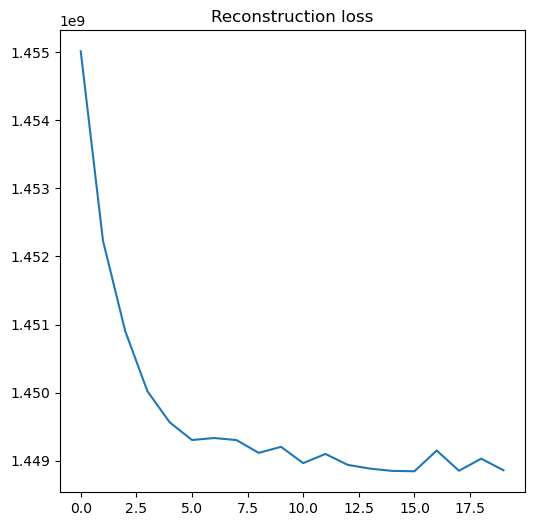

In [19]:
plt.plot(loss_sgd)
plt.title("Reconstruction loss")

And we display the final reconstructed volume (in maximum intensity projection).

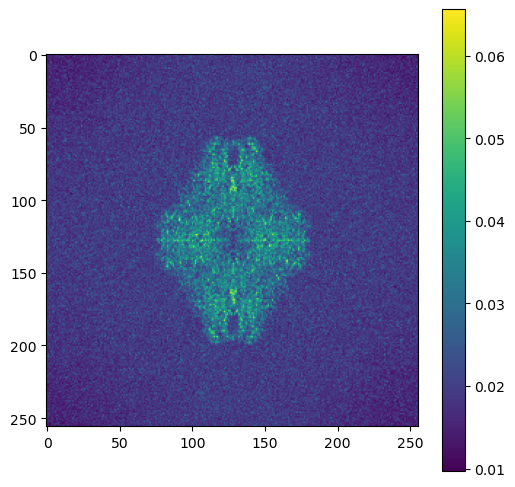

In [20]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_sgd)))

mip_z(vr_sgd)
plt.colorbar()

### Preconditioned SGD

We can also run a preconditioned version of the SGD algorithm, which estimates the diagonal of the Hessian matrix of the loss function and uses it as a preconditioner.

The diagonal $D$ of the Hessian matrix $H$ is estimated using Hutchinson's diagonal estimator:
$$ D = \mathbb{E}[z \odot Hz] $$
where $z$ is a Rademacher vector (its elements are $+1$ or $-1$ with equal probability) and $\odot$ denotes element-wise multiplication. This computation can be done using minibatches and is efficiently implemented using automatic differentiation in JAX without forming the matrix $H$.

In [21]:
# Initialization of the diagonal
D0 = jnp.ones(v0.shape)

# Parameters specific to preconditioned SGD,
# see the documentation of precon_sgd for details.
beta = 0.5
thresh = 1e-1

In [22]:
key, key_alg = random.split(key)

v_sgdp, loss_sgdp, _, _ = precon_sgd(
    key_alg,
    loss_func,
    grad_func,
    hvp_func,
    v0,
    step_size,
    D0,
    beta,
    thresh,
    N_epochs,
    batch_size,
    N,
    c=c,
    adaptive_step_size=True,
    iter_display=1,
)

Epoch 1/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/it, eta=2.150e+00, loss=1.452e+09]


  Loss =  1.45484759e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 2/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.24it/s, eta=2.150e+00, loss=1.449e+09]


  Loss =  1.45160714e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 3/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.25it/s, eta=2.150e+00, loss=1.452e+09]


  Loss =  1.45011114e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 4/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.24it/s, eta=2.150e+00, loss=1.449e+09]


  Loss =  1.44933390e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 5/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.24it/s, eta=2.150e+00, loss=1.447e+09]


  Loss =  1.44890154e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 6/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.25it/s, eta=2.150e+00, loss=1.445e+09]


  Loss =  1.44874675e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 7/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.28it/s, eta=2.150e+00, loss=1.446e+09]


  Loss =  1.44860157e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 8/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.26it/s, eta=2.150e+00, loss=1.446e+09]


  Loss =  1.44855578e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 9/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.29it/s, eta=2.150e+00, loss=1.448e+09]


  Loss =  1.44851445e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 10/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.28it/s, eta=2.150e+00, loss=1.446e+09]


  Loss =  1.44848289e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 11/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.24it/s, eta=2.150e+00, loss=1.445e+09]


  Loss =  1.44841567e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 12/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.29it/s, eta=2.150e+00, loss=1.448e+09]


  Loss =  1.44840485e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 13/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.30it/s, eta=2.150e+00, loss=1.448e+09]


  Loss =  1.44850710e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 14/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.31it/s, eta=2.150e+00, loss=1.445e+09]


  Loss =  1.44839364e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 15/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.26it/s, eta=2.150e+00, loss=1.448e+09]


  Loss =  1.44839813e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 16/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.27it/s, eta=2.150e+00, loss=1.446e+09]


  Loss =  1.44848347e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 17/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.27it/s, eta=2.150e+00, loss=1.448e+09]


  Loss =  1.44839666e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 18/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.22it/s, eta=2.150e+00, loss=1.450e+09]


  Loss =  1.44842018e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 19/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.32it/s, eta=2.150e+00, loss=1.451e+09]


  Loss =  1.44838982e+09
  eta = 2.1499084799999997
  alpha= 0.1
Epoch 20/20


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.27it/s, eta=2.150e+00, loss=1.446e+09]


  Loss =  1.44842412e+09
  eta = 2.1499084799999997
  alpha= 0.1


We see improved convergence of preconditioned SGD.

Text(0.5, 1.0, 'Reconstruction loss')

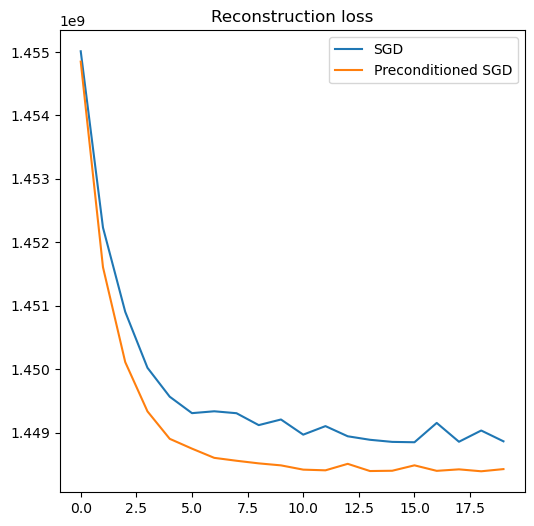

In [23]:
plt.plot(loss_sgd)
plt.plot(loss_sgdp)
plt.legend(["SGD", "Preconditioned SGD"])
plt.title("Reconstruction loss")

And finally display the reconstructed volume using preconditioned SGD.

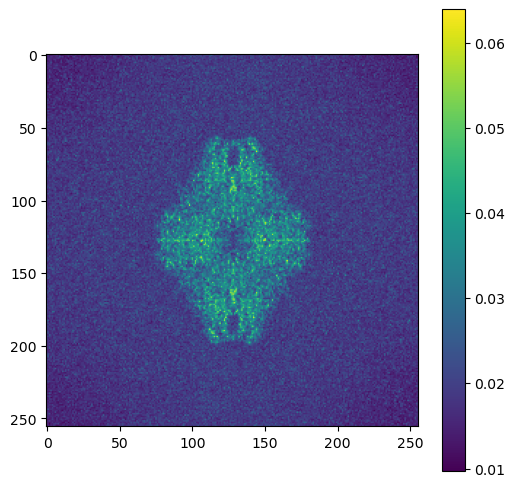

In [25]:
vr_sgdp = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_sgdp)))

mip_z(vr_sgdp)
plt.colorbar()